Data augmentation  
: A technique to increase the diversity of training set by applying a random transformations, such as image rotation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

Download a dataset : tf_flowers

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info = True,
    as_supervised = True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


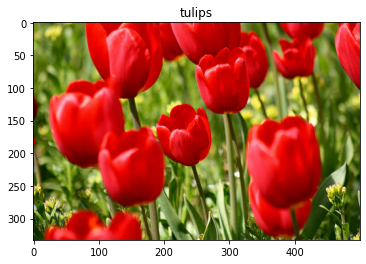

In [4]:
get_label_name = metadata.features['label'].int2str
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

Resizing and rescaling  
: The rescaling layer standardizes pixel value to the [0,1]

In [6]:
IMG_SIZE = 180
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)                            
])

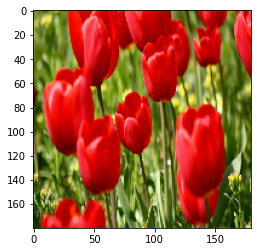

In [7]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [8]:
print("Min and max pixel values : ", result.numpy().min(), result.numpy().max())

Min and max pixel values :  0.0 1.0


Data augmentation

In [9]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)
])

In [16]:
image = tf.expand_dims(image, 0)
data_augmentation(image)

<tf.Tensor: shape=(1, 333, 500, 3), dtype=uint8, numpy=
array([[[[206,   0,   0],
         [210,   0,   0],
         [212,   0,   0],
         ...,
         [ 75,  97,  15],
         [ 80, 102,  15],
         [ 85, 108,  17]],

        [[207,   0,   0],
         [210,   0,   0],
         [212,   0,   0],
         ...,
         [ 71,  93,  14],
         [ 76,  97,  13],
         [ 81, 103,  14]],

        [[205,   0,   0],
         [208,   0,   0],
         [212,   0,   0],
         ...,
         [ 66,  87,  12],
         [ 74,  94,  14],
         [ 80, 100,  14]],

        ...,

        [[176,   2,  14],
         [178,   8,  16],
         [181,  12,  19],
         ...,
         [208, 200,  61],
         [196, 192,  51],
         [162, 167,  32]],

        [[171,   2,   3],
         [175,   4,   8],
         [183,   9,  15],
         ...,
         [231, 218,  71],
         [222, 212,  64],
         [207, 201,  51]],

        [[173,   0,   1],
         [176,   0,   4],
         [181,   2

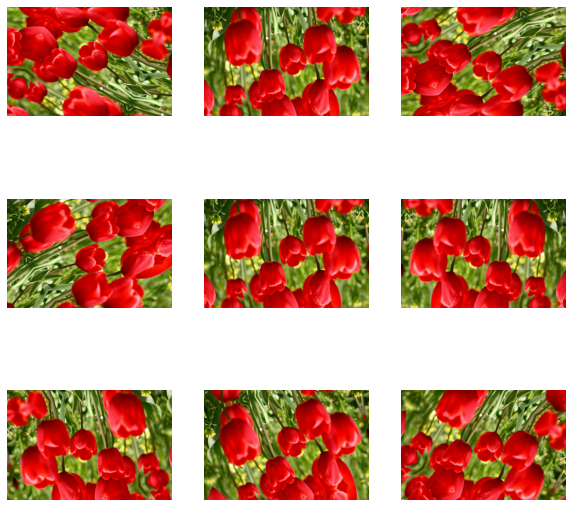

In [ ]:
# Add the image to a batch
image = tf.expand_dims(image, 0)
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3,3,i+1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

preprocessing layers you can use for the data augmentation :  
tf.keras.layers.RandomContrast, tf.keras.layers.RandomCorp, tf.keras.layers.RandomZoom

In [ ]:
# option1 : Make the preprocessing layers part of your model

model = tf.keras.Sequential([
  #Add the preprocessing layers you created earlier
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16,4,padding="same", activation="relu"),
  layers.MaxPooling2D(),
  #Rest of your model
])

In [17]:
# option2 : Applying the preprocessing layers to your dataset

aug_ds = train_ds.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
)

In [18]:
aug_ds

<MapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.int64)>

You use Dataset.map to create a dataset that yields batches of augmented images.

Apply the preprocessing layers to the datasets

In [ ]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False) :
  #Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)
  if shuffle :
    ds = ds.shuffle(1000)

  #Batch all datasets
  ds = ds.batch(batch_size)

  #Use data augmentation only on the training set
  if augment :
    ds = ds.map(lambda x, y : (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
  
  #Use buffered prefetching on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

Train a model

In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(16,3,padding="same", activation="relu"),
  layers.MaxPooling2D(),
  layers.Conv2D(32,3,padding="same", activation="relu"),
  layers.MaxPooling2D(),
  layers.Conv2D(64,3,padding="same", activation="relu"),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer="adam", 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    train_ds, 
    validation_data = val_ds,
    epochs=5
)

Epoch 1/5
92/92 [==============================] - 27s 161ms/step - loss: 1.2642 - accuracy: 0.4632 - val_loss: 1.1282 - val_accuracy: 0.5204
Epoch 2/5
92/92 [==============================] - 13s 130ms/step - loss: 1.0192 - accuracy: 0.5889 - val_loss: 0.9249 - val_accuracy: 0.6730
Epoch 3/5
92/92 [==============================] - 12s 126ms/step - loss: 0.9264 - accuracy: 0.6219 - val_loss: 0.9399 - val_accuracy: 0.6104
Epoch 4/5
92/92 [==============================] - 13s 130ms/step - loss: 0.8935 - accuracy: 0.6465 - val_loss: 0.9613 - val_accuracy: 0.6485
Epoch 5/5
92/92 [==============================] - 12s 129ms/step - loss: 0.8375 - accuracy: 0.6700 - val_loss: 0.8332 - val_accuracy: 0.6921


In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 1s 61ms/step - loss: 0.7750 - accuracy: 0.6785
Accuracy 0.6784741282463074
